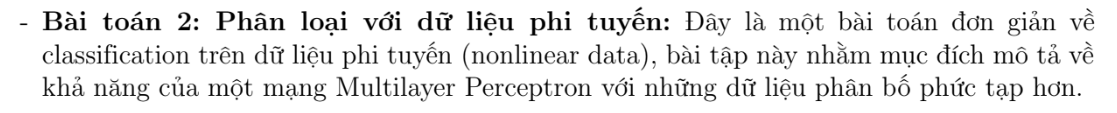

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# Datasets pre-processing

In [3]:
data_path = 'NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

In [80]:
X.shape, y.shape

((300, 2), (300,))

In [81]:
X[:5], y[:5]

(array([[0.        , 0.        ],
        [0.00096008, 0.01005528],
        [0.01045864, 0.01728405],
        [0.00087922, 0.03029027],
        [0.00991727, 0.03916803]]),
 array([0, 0, 0, 0, 0], dtype=uint8))

In [4]:
# one hot encoding
class_num = np.unique(y, axis=0).shape[0]
n_samples = y.shape[0]
y_encoded = np.array(
    [np.zeros(class_num) for _ in range(n_samples)]
)
y_encoded[np.arange(n_samples), y] = 1

print(y_encoded[:5])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [5]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [6]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 210
Number of val samples: 60
Number of test samples: 30


In [7]:
normalizer = StandardScaler ()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train , dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# Pytorch DataLoader

In [8]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [14]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False)

# Build MLP network

In [98]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out

In [99]:
input_dims = X_train.shape[1]
output_dims = class_num
hidden_dims = 128

model = MLP(input_dims, hidden_dims, output_dims).to(device)

# Initiate loss function and optimizer

In [100]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Accuracy function

In [101]:
def compute_accuracy(y_hat, y_true):
    y_hat = torch.Tensor(y_hat).to(device)
    y_true = torch.Tensor(y_true).to(device)
    y_hat = torch.argmax(y_hat, dim=1)
    y_true = torch.argmax(y_true, dim=1)
    correct = (y_hat == y_true).float().sum()
    accuracy = correct / len(y_true)
    return accuracy.detach().cpu().numpy()

# Training

In [102]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [103]:
for epoch in range(epochs):
    train_batch_loss = []
    train_target = []
    train_predict = []

    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        y_pred = model(X_samples)
        # compute avg loss in a batch
        loss = criterion(y_pred, y_samples)
        loss.backward()
        optimizer.step()

        train_batch_loss.append(loss.item())
        train_predict.append(y_pred.detach().cpu())
        train_target.append(y_samples.cpu())
    
    epoch_train_loss = np.mean(train_batch_loss)
    train_losses.append(epoch_train_loss)
    train_target = torch.cat(train_target)
    train_predict = torch.cat(train_predict)

    train_accs.append(compute_accuracy(train_predict, train_target))
    
    val_batch_loss = []
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            y_pred = model(X_samples)
            loss = criterion(y_pred, y_samples)
            val_batch_loss.append(loss.item())
            val_target.append(y_samples.cpu())
            val_predict.append(y_pred.detach().cpu())

    epoch_val_loss = np.mean(val_batch_loss)
    val_losses.append(epoch_val_loss)
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_accs.append(compute_accuracy(val_predict, val_target))
    
    print(f'EPOCH {epoch+1}:\tTraining loss : {epoch_train_loss: .3f}\tValidation loss : {epoch_val_loss: .3f}')

EPOCH 1:	Training loss :  0.935	Validation loss :  0.882
EPOCH 2:	Training loss :  0.773	Validation loss :  0.877
EPOCH 3:	Training loss :  0.727	Validation loss :  0.815
EPOCH 4:	Training loss :  0.712	Validation loss :  0.797
EPOCH 5:	Training loss :  0.698	Validation loss :  0.784
EPOCH 6:	Training loss :  0.677	Validation loss :  0.760
EPOCH 7:	Training loss :  0.659	Validation loss :  0.739
EPOCH 8:	Training loss :  0.642	Validation loss :  0.719
EPOCH 9:	Training loss :  0.617	Validation loss :  0.713
EPOCH 10:	Training loss :  0.623	Validation loss :  0.691
EPOCH 11:	Training loss :  0.601	Validation loss :  0.669
EPOCH 12:	Training loss :  0.582	Validation loss :  0.672
EPOCH 13:	Training loss :  0.567	Validation loss :  0.639
EPOCH 14:	Training loss :  0.553	Validation loss :  0.629
EPOCH 15:	Training loss :  0.533	Validation loss :  0.611
EPOCH 16:	Training loss :  0.533	Validation loss :  0.599
EPOCH 17:	Training loss :  0.521	Validation loss :  0.589
EPOCH 18:	Training loss

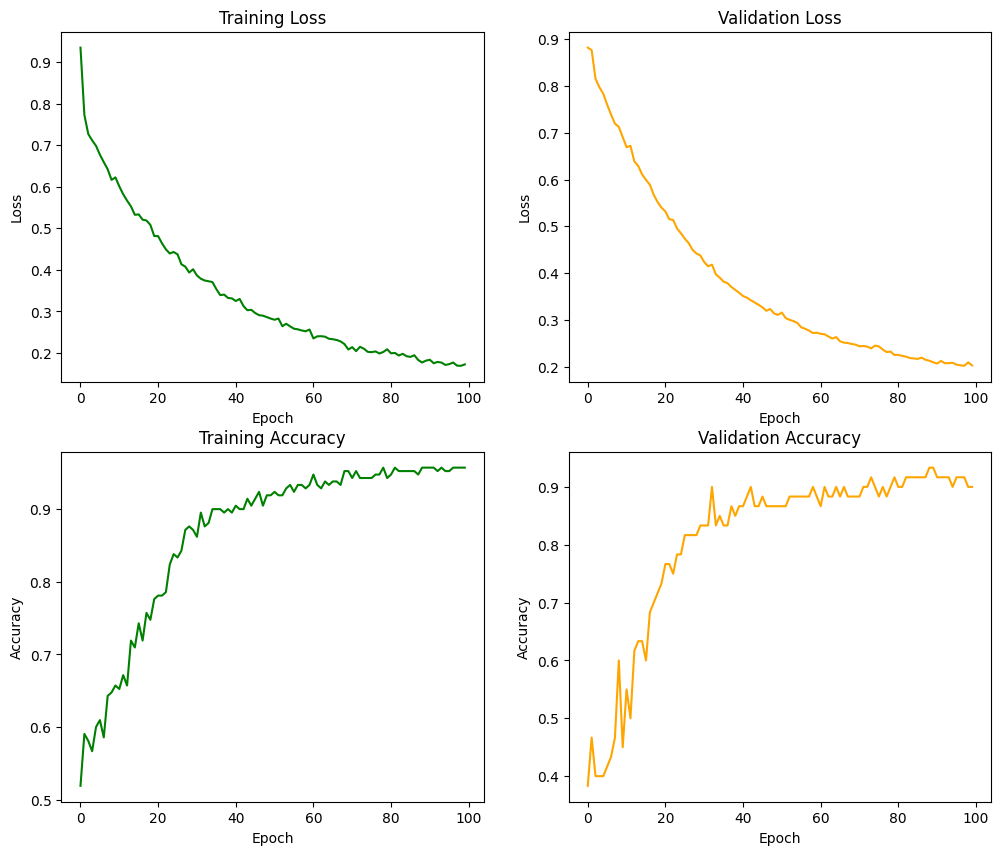

In [104]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# Evaluation

In [106]:
model.eval()
with torch.no_grad():
    X_test = torch.Tensor(X_test).to(device)
    y_hat = model(X_test)
    test_acc = compute_accuracy(y_hat, y_test)
    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.9000000357627869
